<a href="https://colab.research.google.com/github/DineshKPendyala/cryceleb1/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning ECAPA-TDNN on  [CryCeleb2023](https://huggingface.co/spaces/competitions/CryCeleb2023) using [SpeechBrain](https://speechbrain.readthedocs.io)

This notebook should help you get started training your own models for CryCeleb2023 challenge.

Note that it is provides basic example for simplicity and speed.

Author: David Budaghyan (Ubenwa)


### Imports

In [1]:
# For Colab - uncomment and run the following to set up the repo
# !pip install speechbrain
# !git clone https://github.com/Ubenwa/cryceleb2023.git
# %cd cryceleb2023

In [3]:
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
!pip install git+https://github.com/Ubenwa/cryceleb2023.git # This line installs crybrain from the GitHub repo
!git clone https://github.com/Ubenwa/cryceleb2023.git
%cd cryceleb2023

  Cloning https://github.com/Ubenwa/cryceleb2023.git to /tmp/pip-req-build-dnmxxtez
  Running command git clone --filter=blob:none --quiet https://github.com/Ubenwa/cryceleb2023.git /tmp/pip-req-build-dnmxxtez
  Resolved https://github.com/Ubenwa/cryceleb2023.git to commit 5ffad68a1a7a4d739d119daa4efb3260ef0e0e96
ERROR: git+https://github.com/Ubenwa/cryceleb2023.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Cloning into 'cryceleb2023'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 36 (delta 13), reused 22 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 27.42 KiB | 13.71 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/cryceleb2023


In [7]:
%%capture
%load_ext autoreload
%autoreload 2

import pathlib
import random

import numpy as np
import pandas as pd
import seaborn as sns
import speechbrain as sb
import torch
from huggingface_hub import hf_hub_download
from hyperpyyaml import load_hyperpyyaml
from IPython.display import display
from speechbrain.dataio.dataio import read_audio, write_audio
from speechbrain.dataio.dataset import DynamicItemDataset
from speechbrain.dataio.encoder import CategoricalEncoder


In [20]:
from google.colab import drive

drive.mount('/content/drive')

In [30]:

from crybrain import CryBrain, download_data

dataset_path = "data"


### Download data

You need to log in to HuggingFace to be able to download the dataset

In [26]:
from huggingface_hub import notebook_login

notebook_login()

In [31]:
download_data(dataset_path)

In [32]:
# read metadata
metadata = pd.read_csv(
    f"{dataset_path}/metadata.csv", dtype={"baby_id": str, "chronological_index": str}
)
train_metadata = metadata.loc[metadata["split"] == "train"].copy()
display(
    train_metadata.head()
    .style.set_caption("train_metadata")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(train_metadata.describe())

,baby_id,period,duration,split,chronological_index,file_name,file_id
45,0369,B,1.160000,train,000,audio/train/0369/B/0369_B_000.wav,0369_B_000
46,0369,B,0.830000,train,001,audio/train/0369/B/0369_B_001.wav,0369_B_001
47,0369,B,1.320000,train,002,audio/train/0369/B/0369_B_002.wav,0369_B_002
48,0369,B,0.890000,train,003,audio/train/0369/B/0369_B_003.wav,0369_B_003
49,0369,B,0.920000,train,004,audio/train/0369/B/0369_B_004.wav,0369_B_004


,duration
count,18190.000000
mean,0.884927
std,0.539273
min,0.080000
25%,0.580000
50%,0.770000
75%,1.050000
max,10.340000


### Concatenate cry sounds

We are given short cry sounds for each baby. Here we simply concatenate them.

,baby_id,period,duration,file_path
0,0006,B,30.170500,data/concatenated_audio_train/0006_B.wav
1,0007,B,35.722313,data/concatenated_audio_train/0007_B.wav
2,0008,B,55.656375,data/concatenated_audio_train/0008_B.wav
3,0015,B,28.328750,data/concatenated_audio_train/0015_B.wav
4,0018,B,15.252750,data/concatenated_audio_train/0018_B.wav
...,...,...,...,...
929,1076,B,38.263500,data/concatenated_audio_train/1076_B.wav
930,1076,D,16.064750,data/concatenated_audio_train/1076_D.wav
931,1078,B,10.075750,data/concatenated_audio_train/1078_B.wav
932,1078,D,12.114937,data/concatenated_audio_train/1078_D.wav


Text(0.5, 1.0, 'Histogram of Concatenated Cry Sound Lengths')

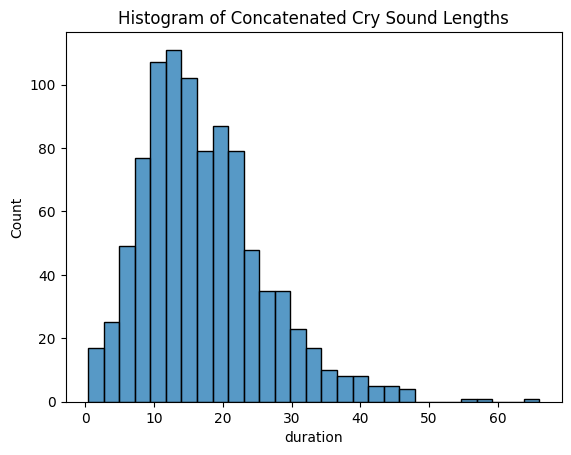

In [33]:
# read the segments
train_metadata["cry"] = train_metadata.apply(
    lambda row: read_audio(f'{dataset_path}/{row["file_name"]}').numpy(), axis=1
)
# concatenate all segments for each (baby_id, period) group
manifest_df = pd.DataFrame(
    train_metadata.groupby(["baby_id", "period"])["cry"].agg(lambda x: np.concatenate(x.values)),
    columns=["cry"],
).reset_index()
# all files have 16000 sampling rate
manifest_df["duration"] = manifest_df["cry"].apply(len) / 16000
pathlib.Path(f"{dataset_path}/concatenated_audio_train").mkdir(exist_ok=True)
manifest_df["file_path"] = manifest_df.apply(
    lambda row: f"{dataset_path}/concatenated_audio_train/{row['baby_id']}_{row['period']}.wav",
    axis=1,
)
manifest_df.apply(
    lambda row: write_audio(
        filepath=f'{row["file_path"]}', audio=torch.tensor(row["cry"]), samplerate=16000
    ),
    axis=1,
)
manifest_df = manifest_df.drop(columns=["cry"])
display(manifest_df)
ax = sns.histplot(manifest_df, x="duration")
ax.set_title("Histogram of Concatenated Cry Sound Lengths")

During training, we will extract random cuts of 3-5 seconds from concatenated audio

In [35]:
def create_cut_length_interval(row, cut_length_interval):
    """cut_length_interval is a tuple indicating the range of lengths we want our chunks to be.
    this function computes the valid range of chunk lengths for each audio file
    """
    # the lengths are in seconds, convert them to frames
    cut_length_interval = [round(length * 16000) for length in cut_length_interval]
    cry_length = round(row["duration"] * 16000)
    # make the interval valid for the specific sound file
    min_cut_length, max_cut_length = cut_length_interval
    # if min_cut_length is greater than length of cry, don't cut
    if min_cut_length >= cry_length:
        cut_length_interval = (cry_length, cry_length)
    # if max_cut_length is greater than length of cry, take a cut of length between min_cut_length and full length of cry
    elif max_cut_length >= cry_length:
        cut_length_interval = (min_cut_length, cry_length)
    return cut_length_interval


cut_length_interval = (3, 5)
manifest_df["cut_length_interval_in_frames"] = manifest_df.apply(
    lambda row: create_cut_length_interval(row, cut_length_interval=cut_length_interval), axis=1
)

### Split into train and val

For training a classfier, we can split the data into train/val in any way, as long as val does not contain new classes

One way to split is to split by period: train on birth recordings and validate on discharge

In [36]:
# we can train on any subset of babies (e.g. to reduce the number of classes, only keep babies with long enough cries, etc)
def get_babies_with_both_recordings(manifest_df):
    count_of_periods_per_baby = manifest_df.groupby("baby_id")["period"].count()
    baby_ids_with_recording_from_both_periods = count_of_periods_per_baby[
        count_of_periods_per_baby == 2
    ].index
    return baby_ids_with_recording_from_both_periods


# def get_babies_with_a_birth_recording(manifest_df):
#   bool_series = manifest_df.groupby('baby_id')['period'].unique().apply(set(['B']).issubset)
#   baby_ids_with_a_recordings_from_birth = bool_series[bool_series].index
#   return baby_ids_with_a_recordings_from_birth


def split_by_period(row, included_baby_ids):
    if row["baby_id"] in included_baby_ids:
        if row["period"] == "B":
            return "train"
        else:
            return "val"
    else:
        return "not_used"


babies_with_both_recordings = get_babies_with_both_recordings(manifest_df)
manifest_df["split"] = manifest_df.apply(
    lambda row: split_by_period(row, included_baby_ids=babies_with_both_recordings), axis=1
)

# each instance will be identified with a unique id
manifest_df["id"] = manifest_df["baby_id"] + "_" + manifest_df["period"]
display(manifest_df)
display(
    manifest_df["split"]
    .value_counts()
    .rename("use_babies_with_both_recordings_and_split_by_period")
)
manifest_df.set_index("id").to_json("manifest.json", orient="index")

,baby_id,period,duration,file_path,cut_length_interval_in_frames,split,id
0,0006,B,30.170500,data/concatenated_audio_train/0006_B.wav,"[48000, 80000]",not_used,0006_B
1,0007,B,35.722313,data/concatenated_audio_train/0007_B.wav,"[48000, 80000]",not_used,0007_B
2,0008,B,55.656375,data/concatenated_audio_train/0008_B.wav,"[48000, 80000]",not_used,0008_B
3,0015,B,28.328750,data/concatenated_audio_train/0015_B.wav,"[48000, 80000]",not_used,0015_B
4,0018,B,15.252750,data/concatenated_audio_train/0018_B.wav,"[48000, 80000]",not_used,0018_B
...,...,...,...,...,...,...,...
929,1076,B,38.263500,data/concatenated_audio_train/1076_B.wav,"[48000, 80000]",train,1076_B
930,1076,D,16.064750,data/concatenated_audio_train/1076_D.wav,"[48000, 80000]",val,1076_D
931,1078,B,10.075750,data/concatenated_audio_train/1078_B.wav,"[48000, 80000]",train,1078_B
932,1078,D,12.114937,data/concatenated_audio_train/1078_D.wav,"[48000, 80000]",val,1078_D


,use_babies_with_both_recordings_and_split_by_period
split,
train,348
val,348
not_used,238


### Create dynamic datasets

See SpeechBrain documentation to understand details

In [39]:
# create a dynamic dataset from the csv, only used to create train and val datasets
dataset = DynamicItemDataset.from_json("manifest.json")
baby_id_encoder = CategoricalEncoder()
datasets = {}
# create a dataset for each split
for split in ["train", "val"]:
    # retrieve the desired slice (train or val) and sort by length to minimize amount of padding
    datasets[split] = dataset.filtered_sorted(
        key_test={"split": lambda value: value == split}, sort_key="duration"
    )  # select_n=100
    # create the baby_id_encoded field
    datasets[split].add_dynamic_item(
        baby_id_encoder.encode_label_torch, takes="baby_id", provides="baby_id_encoded"
    )
    # set visible fields
    datasets[split].set_output_keys(["id", "baby_id", "baby_id_encoded", "sig"])


# create the signal field for the val split (no chunking)
datasets["val"].add_dynamic_item(sb.dataio.dataio.read_audio, takes="file_path", provides="sig")

# the label encoder will map the baby_ids to target classes 0, 1, 2, ...
# only use the classes which appear in `train`,
baby_id_encoder.update_from_didataset(datasets["train"], "baby_id")


# for reading the train split, we add chunking
def audio_pipeline(file_path, cut_length_interval_in_frames):
    """Load the signal, and pass it and its length to the corruption class.
    This is done on the CPU in the `collate_fn`."""
    sig = sb.dataio.dataio.read_audio(file_path)
    if cut_length_interval_in_frames is not None:
        cut_length = random.randint(*cut_length_interval_in_frames)
        # pick the start index of the cut
        left_index = random.randint(0, len(sig) - cut_length)
        # cut the signal
        sig = sig[left_index : left_index + cut_length]
    return sig


# create the signal field (with chunking)
datasets["train"].add_dynamic_item(
    audio_pipeline, takes=["file_path", "cut_length_interval_in_frames"], provides="sig"
)

print(datasets["train"][0])

### Fine-tune the classifier

Here we use a very basic example that just trains for 5 epochs

In [40]:
config_filename = "hparams/ecapa_voxceleb_basic.yaml"
overrides = {
    "seed": 3011,
    "n_classes": len(baby_id_encoder),
    "experiment_name": "ecapa_voxceleb_ft_basic",
    "bs": 32,
    "n_epochs": 5,
}
device = "cuda"
run_opts = {"device": device}
###########################################
# Load hyperparameters file with command-line overrides.
with open(config_filename) as fin:
    hparams = load_hyperpyyaml(fin, overrides)
# Create experiment directory
sb.create_experiment_directory(
    experiment_directory=hparams["experiment_dir"],
    hyperparams_to_save=config_filename,
    overrides=overrides,
)

# Initialize the Brain object to prepare for training.
crybrain = CryBrain(
    modules=hparams["modules"],
    opt_class=hparams["opt_class"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

# if a pretrained model is specified, load it
if "pretrained_embedding_model" in hparams:
    sb.utils.distributed.run_on_main(hparams["pretrained_embedding_model"].collect_files)
    hparams["pretrained_embedding_model"].load_collected()

crybrain.fit(
    epoch_counter=crybrain.hparams.epoch_counter,
    train_set=datasets["train"],
    valid_set=datasets["val"],
    train_loader_kwargs=hparams["train_dataloader_options"],
    valid_loader_kwargs=hparams["val_dataloader_options"],
)

/usr/local/lib/python3.11/dist-packages/speechbrain/core.py:796: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=gradscaler_enabled)
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

You can now use embedding_model.ckpt from this recipe and use it in evaluate.ipynb to verify pairs of cries and submit your results!